In [1]:
import bayesnewton
import jax
import objax
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from sklearn.preprocessing import StandardScaler
from convertbng.util import convert_bng, convert_lonlat
import time
from sklearn.model_selection import train_test_split
import datetime
import math   
from jax import vmap
from scipy.stats import beta
import wandb

import cv2
import sys, os
sys.path.append('../Utils')
import model_utils as mutils
import kernels_definitions as kerns
%load_ext autoreload
%autoreload 2

/Users/SeanNassimiha/miniforge3/envs/mscjax_dev/lib/python3.8/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
#DATA VARIABLES
SYSTEMS_NUM = 5
TIMESTEPS_NUM = 50000
TRAIN_FRAC = 24  #IF TRAIN_FRAC > 1 THEN IT BECOMES THE LENGTH OF THE TEST SET
GRID_PIXELS = 10

#OPTIMISATION VARIABLES
LR_ADAM = 0.01
LR_NEWTON = 0.5
ITERS = 3

#GP Variables
VAR_Y = 0.1
LEN_SPACE = 0.5
LEN_ALTITUDE = 0.3

#PERIODIC KERNEL
VAR_PERIOD = 1.5
VAR_MATERN = 1
LEN_MATERN = 24 /  (TIMESTEPS_NUM / 100) #48
LEN_PERIOD = 400 /  (TIMESTEPS_NUM / 100)#24

#Want to use a sparse approximation
SPARSE = True
#Should we optimise the inducing points
OPT_Z = False  # will be set to False if SPARSE=SPARSE

#use a mean field approximation?
MEAN_FIELD = True
MINI_BATCH_SIZE = None #none if you don't want them
TEST_STATIONS = 10

In [3]:
config = dict (

                SYSTEMS_NUM = 5,
                TIMESTEPS_NUM = 50000,
                TRAIN_FRAC = 24 , #IF TRAIN_FRAC > 1 THEN IT BECOMES THE LENGTH OF THE TEST SET
                GRID_PIXELS = 10,

                #OPTIMISATION VARIABLES
                LR_ADAM = 0.01,
                LR_NEWTON = 0.5,
                ITERS = 3,

                #GP Variables
                VAR_Y = 0.1,
                LEN_SPACE = 0.5,
                LEN_ALTITUDE = 0.3,

                #PERIODIC KERNEL
                VAR_PERIOD = 1.5,
                VAR_MATERN = 1,
                LEN_MATERN = 24 /  (TIMESTEPS_NUM / 100),   
                LEN_PERIOD = 400 /  (TIMESTEPS_NUM / 100),  

                #Want to use a sparse approximation
                SPARSE = True,
                #Should we optimise the inducing points
                OPT_Z = False,  # will be set to False if SPARSE=SPARSE

                #use a mean field approximation?
                MEAN_FIELD = True,
                MINI_BATCH_SIZE = None, #none if you don't want them
                TEST_STATIONS = 10,

)

wandb.init(project="Nowcasting", entity="snassimiha")


wandb: Currently logged in as: snassimiha. Use `wandb login --relogin` to force relogin


In [4]:
data =  pd.read_csv('../../Data/pv_power_df_5day_capacity_scaled.csv', index_col='datetime')
uk_pv = pd.read_csv('../../Data/system_metadata_location_rounded.csv')
uk_pv['ss_id_string'] = uk_pv['ss_id'].astype('str')
#data_multiple.plot(legend=False)
lats = dict(uk_pv.set_index('ss_id')['latitude_noisy'])
longs = dict(uk_pv.set_index('ss_id')['longitude_noisy'])
data_multiple = data.sample(frac=1, axis=1).iloc[:, :SYSTEMS_NUM][:TIMESTEPS_NUM].reset_index()
stacked = mutils.stack_dataframe(data_multiple, lats, longs)
capacities = uk_pv[uk_pv.ss_id_string.isin(data_multiple.columns)].set_index('ss_id_string')['kwp'].values * 1000



In [5]:
X = np.array(stacked[['epoch', 'longitude', 'latitude']])
Y = np.array(stacked[['PV']])

# convert to easting and northings
british_national_grid_coords = convert_bng(X[:, 1], X[:, 2])
X = np.vstack([X[:, 0],
              np.array(british_national_grid_coords[0]),
              np.array(british_national_grid_coords[1])]).T

#Create a space-time grid from X and Y
t, R, Y = bayesnewton.utils.create_spatiotemporal_grid(X, Y)
#SCALING THE t HERE
t = t / (TIMESTEPS_NUM / 100)


/Users/SeanNassimiha/miniforge3/envs/mscjax_dev/lib/python3.8/site-packages/geopandas/array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


Text(0.5, 1.0, 'Grid of initial inducing points')

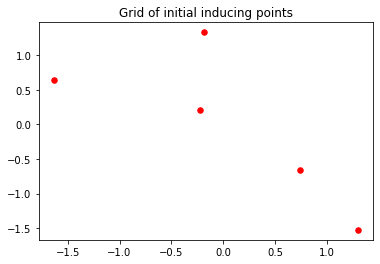

In [6]:
#train test split for 3 dimensional data
t_train, t_test, R_train, R_test, Y_train, Y_test = mutils.train_split_3d(t, R, Y, train_frac = TRAIN_FRAC, split_type = 'Cutoff')
Y = Y[:,:,0]

#get the mask of the test points
test_mask = np.in1d(t.squeeze(), t_test.squeeze())

#Scale the data
scaled_values = mutils.scale_2d_train_test_data(R, Y, R_train, R_test, Y_train, Y_test )
R_scaler, R_scaled, R_train_scaled, R_test_scaled, _, _, _, _ = scaled_values

#here get a list of scaled coordinates (frozen because at some point in time)
R_scaled_frozen = R_scaled[0]

# #Create a grid to perform prediction/interpolation on
r1, r2, Rplot = mutils.create_grid_from_coords(R = R_scaled_frozen, t = t, R_scaler = R_scaler, N_pixels = GRID_PIXELS, date_solar = None)

z = R_scaled[2, ...]
    
plt.scatter(*zip(*z[:, :2]), marker='o', s=30, color='red')
plt.title('Grid of initial inducing points')



In [7]:
#FIXED WINDOW OF 5000 train and 24 test, the 5000 train slide forward
length_window = 97 * 10
max_t = 14000 #len(data_multiple) - length_window - 24
iter_step = 50
#HERE BUILDING ARRAY OF STARTING ts
data_multiple = data_multiple.set_index('datetime')
data_multiple.index = pd.to_datetime(data_multiple.index)
array_of_indices = data_multiple.reset_index()[(data_multiple.reset_index().datetime.dt.hour > 9) & (data_multiple.reset_index().datetime.dt.hour < 14)].index.values
data_multiple = data_multiple.reset_index()
range_idx = array_of_indices[10000:max_t:iter_step]

In [15]:
t1 = time.time()
print(f'Getting results for Gaussian Process')

errors = np.zeros((24, 1))
NNLs = np.zeros((24, 1))

forecast_size = 24
for t_idx in range_idx[:3]: 
    print('NEW ITERATION WITH t:',t_idx)
        
    t_iter, R_iter, Y_iter = t[t_idx:t_idx+length_window + 24], R_scaled[t_idx:t_idx+length_window + 24], Y[t_idx:t_idx+length_window + 24]    
    t_train_CV, R_train_scaled_CV, Y_train_CV = t_iter[:length_window] , R_iter[:length_window] , Y_iter[:length_window]  
    t_test_CV, R_test_scaled_CV, Y_test_CV = t_iter[length_window:] , R_iter[length_window:] , Y_iter[length_window:]  
    print(f'TRAIN SIZE IS: t_train_CV: {t_train_CV.shape}, R_train_scaled_CV: {R_train_scaled_CV.shape}, Y_train_CV :{Y_train_CV.shape}')
    print(f'TEST SIZE IS: t_test_CV: {t_test_CV.shape}, R_test_scaled_CV: {R_test_scaled_CV.shape}, Y_test_CV :{Y_test_CV.shape}')

    #IF WE ARE IN THE FIRST ITERATION
    if t_idx == range_idx[0]:
        
        kern = kerns.get_periodic_kernel(variance_period = VAR_PERIOD, 
                                         variance_matern = VAR_MATERN, 
                                         lengthscale_time_period = LEN_PERIOD, 
                                         lengthscale_time_matern = LEN_MATERN,
                                           lengthscale_space=[LEN_SPACE, LEN_SPACE], #[LEN_SPACE, LEN_SPACE, LEN_ALTITUDE]
                                           z=z,
                                           sparse=SPARSE,
                                           opt_z=OPT_Z,
                                           conditional='Full',
                                           matern_order = '32',
                                           order= 2)

        lik = bayesnewton.likelihoods.Beta(scale = 30, fix_scale=False, link='probit')
    
    model = bayesnewton.models.MarkovVariationalMeanFieldGP(kernel = kern, likelihood = lik, X=t_train_CV, Y=Y_train_CV, R=R_train_scaled_CV)
    
    #IF WE ARE NOT IN THE FIRST ITERATION, WARM-START THE TRAINING
    if t_idx != range_idx[0]:
        print('Warm starting the training')
        #HERE I AM SUBSTITUTING THE PREDICTIONS ETC FROM THE MODEL IN THE TRAINING LOCATIONS
        for key in model.vars().keys():
            if model.vars()[key].shape  == ():
                continue
            else:
                if model.vars()[key].shape[0] == len(t_train_CV):
                    shared_var = model.vars()[key] 
                    init_array = jax.numpy.pad(previous_model.vars()[key][iter_step:], ((0,iter_step), (0,0), (0,0)))
                    shared_var.assign(init_array) 

    
    opt_hypers = objax.optimizer.Adam(model.vars())
    energy = objax.GradValues(model.energy, model.vars())
    
    @objax.Function.with_vars(model.vars() + opt_hypers.vars())
    def train_op(batch_ind = None):
        model.inference(lr=LR_NEWTON, batch_ind = batch_ind)  #perform inference and update variational params
        dE, E = energy()  # compute energy and its gradients w.r.t. hypers
        opt_hypers(LR_ADAM, dE)
    train_op = objax.Jit(train_op)

    @objax.Function.with_vars(model.vars())
    def reduced_train_op(batch_ind = None):
        model.inference(lr=LR_NEWTON, batch_ind = batch_ind)  #perform inference and update variational params
    reduced_train_op = objax.Jit(reduced_train_op)

    print('BEGIN TRAINING')
    t0 = time.time()
    loss = []
    #DOING HALF THE ITERATIONS WHEN UPDATING THE MODEL
    iterations_n = ITERS if t_idx == range_idx[0] else int(ITERS/2) 
    for i in range(1, iterations_n + 1):
        if t_idx == range_idx[0]:
            train_op(None)
        else:
            reduced_train_op(None)
        loss.append(model.compute_kl().item())
        print('iter %2d, energy: %1.4f' % (i, loss[i-1]))
    t1 = time.time()
    print('optimisation time: %2.2f secs' % (t1-t0))
    
    print('Performing the predictions')
    #GET THE SYSTEM SPECIFIC PREDICTIONS (NOT THE TOTAL INTERPOLATION)

    f_mean, f_var = model.predict(X=t_test_CV, R=R_test_scaled_CV)

    #################GET THE Y PREDICTIONS FROM THE F VALUES
    f_mean = f_mean.reshape(f_mean.shape[0], -1, 1)
    f_var = f_var.reshape(f_var.shape[0], -1, 1)

    mean_y, var_y = vmap(model.likelihood.predict, (0, 0, None))(f_mean, f_var, None)
    posterior_mean_ts, posterior_var_ts = np.squeeze(mean_y), np.squeeze(var_y)
    
    ##################GET THE ERRORS
    error = np.nanmean(abs(np.squeeze(Y_test_CV) - np.squeeze(posterior_mean_ts)), axis=1)[:, np.newaxis]
    print(f'mae is {error.mean()} \n')
    
    errors = np.concatenate((errors, error), axis=1)  
    
    #################### GET THE NNL
    
    #SAMPLE THE LATENT VARIABLE AND GET THE SAMPLED DISTRIBUTIONS
    N_samples = 1000
    #Sample values of f at each point
    sampled_f = np.random.normal(f_mean[:,:,0], f_var[:,:,0], size=(N_samples, f_var.shape[0], f_var.shape[1]))

    alpha_sampled = model.likelihood.link_fn(sampled_f) * model.likelihood.scale
    beta_sampled = model.likelihood.scale - alpha_sampled

    #GET THE NEGATIVE LOG LIKELIHOOD GIVEN THE SAMPLED DISTRIBUTION AND THE OBSERVED Y VALUES
    observed_repeated = np.repeat(Y_test_CV[np.newaxis, :, :], N_samples, axis=0)
    observed_repeated = observed_repeated.at[observed_repeated==0].set(10e-6)
    likelihoods = beta.pdf(observed_repeated,  alpha_sampled, beta_sampled)
    NNL_hsteps = -np.sum(np.log(likelihoods.mean(axis=0)), axis=1)[:, np.newaxis]
    
    NNLs = np.concatenate((NNLs, NNL_hsteps), axis=1)  

    #####################
    
    previous_model = model
    
    del t_iter, R_iter, Y_iter, t_train_CV, R_train_scaled_CV, Y_train_CV, t_test_CV, R_test_scaled_CV, Y_test_CV
    del NNL_hsteps, observed_repeated, beta_sampled, alpha_sampled, sampled_f, error, posterior_mean_ts, posterior_var_ts
    del mean_y, var_y, f_mean, f_var, #model
    
error_evolution = errors[:, 1:].mean(axis=0)
MAE_hsteps = errors[:, 1:].mean(axis=1)
NNLs_hsteps = np.quantile(NNLs[:, 1:], 0.5, axis=1)
NNLs_hsteps_upper = np.quantile(NNLs[:, 1:], 0.975,  axis=1)
NNLs_hsteps_lower = np.quantile(NNLs[:, 1:], 0.025,  axis=1)


error_evolution = pd.DataFrame(error_evolution).rename(columns ={0:'error_evolution'} )
MAE_hsteps = pd.DataFrame(MAE_hsteps).rename(columns ={0:'MAE_hsteps'} )
NNLs_hsteps = pd.DataFrame(NNLs_hsteps).rename(columns ={0:'NNLs_hsteps'} )

wandb.log({"error_evolution": error_evolution,  "MAE_hsteps": MAE_hsteps, "NNLs_hsteps": NNLs_hsteps})



Getting results for Gaussian Process
NEW ITERATION WITH t: 20248
TRAIN SIZE IS: t_train_CV: (970, 1), R_train_scaled_CV: (970, 5, 2), Y_train_CV :(970, 5)
TEST SIZE IS: t_test_CV: (24, 1), R_test_scaled_CV: (24, 5, 2), Y_test_CV :(24, 5)
BEGIN TRAINING
iter  1, energy: 1253.5649
iter  2, energy: 1277.4711
iter  3, energy: 1457.3493
optimisation time: 124.58 secs
Performing the predictions
mae is 0.2669610874076859 

NEW ITERATION WITH t: 20347
TRAIN SIZE IS: t_train_CV: (970, 1), R_train_scaled_CV: (970, 5, 2), Y_train_CV :(970, 5)
TEST SIZE IS: t_test_CV: (24, 1), R_test_scaled_CV: (24, 5, 2), Y_test_CV :(24, 5)
Warm starting the training
BEGIN TRAINING
iter  1, energy: 1612.6318
optimisation time: 5.55 secs
Performing the predictions
mae is 0.1949208392814754 

NEW ITERATION WITH t: 20446
TRAIN SIZE IS: t_train_CV: (970, 1), R_train_scaled_CV: (970, 5, 2), Y_train_CV :(970, 5)
TEST SIZE IS: t_test_CV: (24, 1), R_test_scaled_CV: (24, 5, 2), Y_test_CV :(24, 5)
Warm starting the trainin

/Users/SeanNassimiha/miniforge3/envs/mscjax_dev/lib/python3.8/site-packages/numpy/lib/function_base.py:4011: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a*t, out=out))


In [ ]:
# ##################GET THE ERRORS
# error = np.nanmean(abs(np.squeeze(Y_test_CV) - np.squeeze(posterior_mean_ts)), axis=1)[:, np.newaxis]
# print(f'mae is {error.mean()} \n')

# errors = np.concatenate((errors, error), axis=1)  

# #################### GET THE NNL

# #SAMPLE THE LATENT VARIABLE AND GET THE SAMPLED DISTRIBUTIONS
# N_samples = 1000
# #Sample values of f at each point
# sampled_f = np.random.normal(f_mean[:,:,0], f_var[:,:,0], size=(N_samples, f_var.shape[0], f_var.shape[1]))

# alpha_sampled = model.likelihood.link_fn(sampled_f) * model.likelihood.scale
# beta_sampled = model.likelihood.scale - alpha_sampled

# #GET THE NEGATIVE LOG LIKELIHOOD GIVEN THE SAMPLED DISTRIBUTION AND THE OBSERVED Y VALUES
# observed_repeated = np.repeat(Y_test_CV[np.newaxis, :, :], N_samples, axis=0)
# observed_repeated = observed_repeated.at[observed_repeated==0].set(10e-6)
# likelihoods = beta.pdf(observed_repeated,  alpha_sampled, beta_sampled)
# NNL_hsteps = -np.sum(np.log(likelihoods.mean(axis=0)), axis=1)[:, np.newaxis]

# NNLs = np.concatenate((NNLs, NNL_hsteps), axis=1)  

# #####################

# previous_model = model

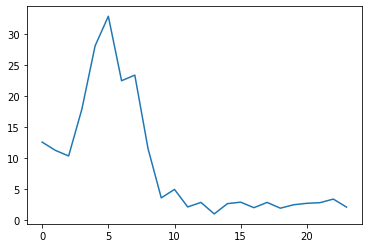

In [16]:
plt.plot(NNLs_hsteps)

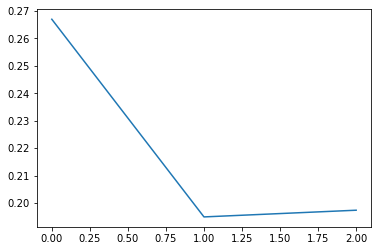

In [17]:
plt.plot(error_evolution)

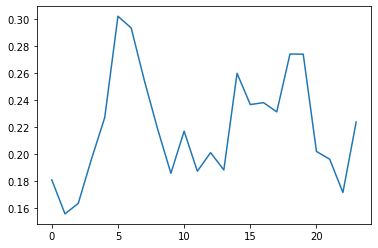

In [18]:
plt.plot(MAE_hsteps)

In [ ]:
pd.DataFrame(NNLs_hsteps).rename(columns ={0:'NNLs_hsteps'} ).to_csv('NNLs_hsteps')
pd.DataFrame(error_evolution).rename(columns ={0:'error_evolution'} ).to_csv('error_evolution')
pd.DataFrame(MAE_hsteps).rename(columns ={0:'MAE_hsteps'} ).to_csv('MAE_hsteps')

In [ ]:
t_iter, R_iter, Y_iter = t[t_idx:t_idx+length_window + 24], R_scaled[t_idx:t_idx+length_window + 24], Y[t_idx:t_idx+length_window + 24]    
t_train_CV, R_train_scaled_CV, Y_train_CV = t_iter[:length_window] , R_iter[:length_window] , Y_iter[:length_window]  
t_test_CV, R_test_scaled_CV, Y_test_CV = t_iter[length_window:] , R_iter[length_window:] , Y_iter[length_window:]  

In [ ]:
#GET THE SYSTEM SPECIFIC PREDICTIONS (NOT THE TOTAL INTERPOLATION)
len_samples = len(t_test_CV) + 50
test_mask_shortened = test_mask[-len_samples:]

f_mean, f_var = model.predict(X=t[-len_samples:], R=R_scaled[-len_samples:])

#GET THE Y PREDICTIONS FROM THE F VALUES
f_mean = f_mean.reshape(f_mean.shape[0], -1, 1)
f_var = f_var.reshape(f_var.shape[0], -1, 1)

mean_y, var_y = vmap(model.likelihood.predict, (0, 0, None))(f_mean, f_var, None)
posterior_mean_ts, posterior_var_ts = np.squeeze(mean_y), np.squeeze(var_y)

#GET THE ERRORS
print(f'testing using the next {len(Y[-len_samples:][test_mask_shortened])} datapoints')
error = np.nanmean(abs(np.squeeze(Y[-len_samples:][test_mask_shortened]) - np.squeeze(posterior_mean_ts[test_mask_shortened])), axis=1)
print(f'mae is {error}')

# errors = np.concatenate((errors, error))


In [ ]:
t0 = time.time()

#GET THE SYSTEM SPECIFIC PREDICTIONS (NOT THE TOTAL INTERPOLATION)
len_samples = len(t_test) + 500
test_mask_shortened = test_mask[-len_samples:]

f_mean, f_var = model.predict(X=t[-len_samples:], R=R_scaled[-len_samples:])

#GET THE Y PREDICTIONS FROM THE F VALUES
f_mean = f_mean.reshape(f_mean.shape[0], -1, 1)
f_var = f_var.reshape(f_var.shape[0], -1, 1)

mean_y, var_y = vmap(model.likelihood.predict, (0, 0, None))(f_mean, f_var, None)
posterior_mean_ts, posterior_var_ts = np.squeeze(mean_y), np.squeeze(var_y)

t1 = time.time()
print('prediction time: %2.2f secs' % (t1-t0))

In [ ]:
#GET THE PREDICTION INTERVALS AND CALCULATE ERRORS

posterior_pos_twostd_rescaled = posterior_mean_ts + 1.96 * np.sqrt(posterior_var_ts)
posterior_neg_twostd_rescaled = posterior_mean_ts - 1.96 * np.sqrt(posterior_var_ts)

rescaled_Y = (Y ) #* capacities)
rescaled_posterior = posterior_mean_ts#) #* capacities

#adjust this for the correct quantities
mae = np.nanmean(abs(np.squeeze(rescaled_Y[-len_samples:]) - np.squeeze(rescaled_posterior)))
print(f'The MAE is {mae.round(3)}')

mae_train = np.nanmean(abs(np.squeeze(rescaled_Y[-len_samples:][~test_mask_shortened]) - np.squeeze(rescaled_posterior[~test_mask_shortened])))
print(f'The train MAE is {mae_train.round(3)}')

mae_test = np.nanmean(abs(np.squeeze(rescaled_Y[-len_samples:][test_mask_shortened]) - np.squeeze(rescaled_posterior[test_mask_shortened])), axis=1)
plt.figure(figsize=(10,5))
plt.plot(mae_test)
plt.title('Error as function of forecast distance for Gaussian Process on validation test')
plt.xlabel('Number of steps ahead (5min ticks)')
plt.ylabel('Average MW error')

print(f'The average 2 hours test MAE is {mae_test[:24].mean()}')


In [ ]:
#SAMPLE THE UNCERTAINTY BOUNDS

#Sample values of f at each point
sampled_f = np.random.normal(f_mean[:,:,0], f_var[:,:,0], size=(10, f_var.shape[0], f_var.shape[1]))

alpha_sampled = model.likelihood.link_fn(sampled_f) * model.likelihood.scale
beta_sampled = model.likelihood.scale - alpha_sampled

beta_samples = np.random.beta(alpha_sampled, beta_sampled, size=(alpha_sampled.shape[0], alpha_sampled.shape[1], alpha_sampled.shape[2]))
lower_bounds_beta_MC = np.quantile(beta_samples, 0.025, axis=0)
upper_bounds_beta_MC = np.quantile(beta_samples, 0.975, axis=0)


In [ ]:
days_index = max(97, int(((len_samples / 3) // 97) * 97)) #number of time intervals to match 5 beginnings of days

for i in range(SYSTEMS_NUM):
    plt.figure(figsize=(10,7))
    plt.title(f'Prediction for system {i}')
    plt.plot(np.arange(len(Y))[-len_samples:], Y_iter[:,i][-len_samples:], "xk")
    plt.plot(np.arange(len(Y))[-len_samples:], posterior_mean_ts[:,i][-len_samples:], c="C0", lw=2, zorder=2)
#     plt.plot(np.arange(len(Y))[-len_samples:], R[-len_samples:, i, 2], 'green', alpha = 0.1)
    plt.vlines(t_train[-1], 0, 1, colors='k')

#     plt.fill_between(
#         np.arange(len(Y))[-len_samples:],
#         lower_bounds_beta_MC[:,i],
#         upper_bounds_beta_MC[:,i],
#         color="C1",
#         alpha=0.2)
    
    plt.xticks(ticks = np.arange(len(Y_iter))[-len_samples:-1:days_index], labels = data_multiple.datetime[-len_samples:-1:days_index].values, size=8)
    

# WARM START FOR TRAINING

In [ ]:
#FIRST INITIALISE A SECOND MODEL
#THIS INITIALISATION USES THE SAME KERNEL AND LIKELIHOOD!
model2 = bayesnewton.models.MarkovVariationalGP(kernel = kern, likelihood = lik, X=t, Y=Y, R=R_scaled)

In [ ]:
#HERE I AM SUBSTITUTING THE PREDICTIONS ETC FROM THE MODEL IN THE TRAINING LOCATIONS
for key in model2.vars().keys():
    if model2.vars()[key].shape  == ():
        continue
    else:
        if model2.vars()[key].shape[0] == len(t):
            shared_var = model2.vars()[key] 
            init_array = jax.numpy.pad(model.vars()[key], ((0,len(t) - len(t_train)), (0,0), (0,0)))
            shared_var.assign(init_array) 
    


In [ ]:
#THIS IS WHAT IT LOOKS LIKE IN THE MODEL POSTERIOR
plt.plot(model2.vars()['(MarkovVariationalGP).posterior_mean'][:,0])

In [ ]:
@objax.Function.with_vars(model2.vars())
def reduced_train_op(batch_ind = None):
    model2.inference(lr=LR_NEWTON, batch_ind = batch_ind)  #perform inference and update variational params
reduced_train_op = objax.Jit(reduced_train_op)

In [ ]:
t0 = time.time()
loss = []
for i in range(1, 1 + 1):
    for mini_batch in range(number_of_minibatches):
        if number_of_minibatches > 1:
            print(f'Doing minibatch {mini_batch}')
        reduced_train_op(mini_batches_indices[mini_batch])
        loss.append(model2.compute_kl().item())
    print('iter %2d, energy: %1.4f' % (i, loss[i-1]))
t1 = time.time()
print('optimisation time: %2.2f secs' % (t1-t0))
avg_time_taken = (t1-t0)/ITERS

# Compare it to the case without warm start

In [ ]:
#FIRST INITIALISE A SECOND MODEL
#THIS INITIALISATION USES THE SAME KERNEL AND LIKELIHOOD!
kern3 = kerns.get_periodic_kernel(variance=VAR_F,
                                           lengthscale_time=LEN_TIME,
                                           lengthscale_space=[LEN_SPACE, LEN_SPACE],
                                           z=z,
                                           sparse=SPARSE,
                                           opt_z=OPT_Z,
                                           conditional='FIC')

lik3 = bayesnewton.likelihoods.Beta(scale = 30, fix_scale=False, link='probit')
model3 = bayesnewton.models.MarkovVariationalGP(kernel = kern3, likelihood = lik3, X=t, Y=Y, R=R_scaled)

In [ ]:
opt_hypers3 = objax.optimizer.Adam(model3.vars())
energy3 = objax.GradValues(model3.energy, model3.vars())

@objax.Function.with_vars(model3.vars())
def train_op_model3(batch_ind = None):
    model3.inference(lr=LR_NEWTON, batch_ind = batch_ind)  #perform inference and update variational params
    dE, E = energy3()  # compute energy and its gradients w.r.t. hypers
    opt_hypers3(LR_ADAM, dE)
train_op_model3 = objax.Jit(train_op_model3)


In [ ]:
t0 = time.time()
loss = []
for i in range(1, ITERS + 1):
    for mini_batch in range(number_of_minibatches):
        if number_of_minibatches > 1:
            print(f'Doing minibatch {mini_batch}')
        train_op_model3(mini_batches_indices[mini_batch])
        loss.append(model3.compute_kl().item())
    print('iter %2d, energy: %1.4f' % (i, loss[i-1]))
t1 = time.time()
print('optimisation time: %2.2f secs' % (t1-t0))
avg_time_taken = (t1-t0)/ITERS

# IMPLEMENT THE CROSS VALIDATION

# TESTING JIT AND MINIBATCHES

In [ ]:
print(adfiheg)

## JIT + no minibatches

In [ ]:
MINI_BATCH_SIZE = None

if MINI_BATCH_SIZE == None:
    number_of_minibatches = 1
    mini_batches_indices = [None] * number_of_minibatches
else:
    number_of_minibatches = int(len(t_train) / MINI_BATCH_SIZE)
    idx_set = np.arange(len(t_train))
    np.random.shuffle(idx_set)
    mini_batches_indices = np.array_split(idx_set, number_of_minibatches)

In [ ]:
%%timeit

t0 = time.time()
loss = []
for i in range(1, ITERS + 1):
    for mini_batch in range(number_of_minibatches):
#         model.inference(lr=LR_NEWTON, batch_ind = mini_batches_indices[mini_batch])  #perform inference and update variational params
        reduced_train_op(mini_batches_indices[mini_batch])
        loss.append(model.compute_kl().item())
    print('iter %2d, energy: %1.4f' % (i, loss[i-1]))
t1 = time.time()
print('optimisation time: %2.2f secs' % (t1-t0))
avg_time_taken = (t1-t0)/ITERS


## JIT + Time Minibatches

In [ ]:
MINI_BATCH_SIZE = 16

if MINI_BATCH_SIZE == None:
    number_of_minibatches = 1
    mini_batches_indices = [None] * number_of_minibatches
else:
    number_of_minibatches = int(len(t_train) / MINI_BATCH_SIZE)
    idx_set = np.arange(len(t_train))
    np.random.shuffle(idx_set)
    mini_batches_indices = np.array_split(idx_set, number_of_minibatches)
    

In [ ]:
%%timeit

t0 = time.time()
loss = []
for i in range(1, ITERS + 1):
    for mini_batch in range(number_of_minibatches):
#         model.inference(lr=LR_NEWTON, batch_ind = mini_batches_indices[mini_batch])  #perform inference and update variational params
        reduced_train_op(mini_batches_indices[mini_batch])
        loss.append(model.compute_kl().item())
    print('iter %2d, energy: %1.4f' % (i, loss[i-1]))
t1 = time.time()
print('optimisation time: %2.2f secs' % (t1-t0))
avg_time_taken = (t1-t0)/ITERS


## no JIT + time minibatches

In [ ]:
MINI_BATCH_SIZE = 16

if MINI_BATCH_SIZE == None:
    number_of_minibatches = 1
    mini_batches_indices = [None] * number_of_minibatches
else:
    number_of_minibatches = int(len(t_train) / MINI_BATCH_SIZE)
    idx_set = np.arange(len(t_train))
    np.random.shuffle(idx_set)
    mini_batches_indices = np.array_split(idx_set, number_of_minibatches)
    

In [ ]:
%%timeit

t0 = time.time()
loss = []
for i in range(1, ITERS + 1):
    for mini_batch in range(number_of_minibatches):
        model.inference(lr=LR_NEWTON, batch_ind = mini_batches_indices[mini_batch])  #perform inference and update variational params
#         reduced_train_op(mini_batches_indices[mini_batch])
        loss.append(model.compute_kl().item())
    print('iter %2d, energy: %1.4f' % (i, loss[i-1]))
t1 = time.time()
print('optimisation time: %2.2f secs' % (t1-t0))
avg_time_taken = (t1-t0)/ITERS


## no JIT + no minibatches

In [ ]:
MINI_BATCH_SIZE = None

if MINI_BATCH_SIZE == None:
    number_of_minibatches = 1
    mini_batches_indices = [None] * number_of_minibatches
else:
    number_of_minibatches = int(len(t_train) / MINI_BATCH_SIZE)
    idx_set = np.arange(len(t_train))
    np.random.shuffle(idx_set)
    mini_batches_indices = np.array_split(idx_set, number_of_minibatches)
    

In [ ]:
%%timeit

t0 = time.time()
loss = []
for i in range(1, ITERS + 1):
    for mini_batch in range(number_of_minibatches):
        model.inference(lr=LR_NEWTON, batch_ind = mini_batches_indices[mini_batch])  #perform inference and update variational params
#         reduced_train_op(mini_batches_indices[mini_batch])
        loss.append(model.compute_kl().item())
    print('iter %2d, energy: %1.4f' % (i, loss[i-1]))
t1 = time.time()
print('optimisation time: %2.2f secs' % (t1-t0))
avg_time_taken = (t1-t0)/ITERS


## JIT + space minibatches

## no JIT + space minibatches

# INFINITE HORIZON: ONLINE LEARNING?

In [ ]:
model.update_posterior()

## Validation for the model

the Kalman filter usually has the following loop:

- For i in infinity:
    - Get values of t, R (just add one to t and maintain the same R)
    - model.predict(X = t, R = R)
    - model.some_update_fn(Y = Y)

In [ ]:
mean_test, var_test = model.predict_y(X = t_test[0:2], R = R_test[0:2])
for i in range(2, 50, 2):
    mean_test_i, var_test_i = model.predict_y(X = t_test[i:i+5], R = R_test[i:i+5])
    mean_test = np.concatenate([mean_test, mean_test_i])
    var_test = np.concatenate([var_test, var_test_i])
    model.update_posterior()
    model.update_variational_params()

In [ ]:
model.inference()

In [ ]:
mean_test[:,0]

In [ ]:
model.vars()

In [ ]:

posterior_mean_ts, posterior_var_ts = model.predict_y(X=t, R=R_scaled)


In [ ]:
a.shape

In [ ]:
model.posterior_mean

In [ ]:
a = model.posterior_mean
model.X = np.append(t_train, t_test[0])
model.Y = np.append(Y_train, Y_test[0])
model.R = np.append(R_train_scaled, R_test_scaled[0])
model.update_posterior()
b = model.posterior_mean


In [ ]:
(a == b).sum()

In [ ]:
a.shape

In [ ]:
model.posterior_variance.shape

In [ ]:
model.update_variational_params()

In [ ]:
model.update_posterior()

In [ ]:
# model.history

In [ ]:
model.filter(1, model.kernel, 0.5, model.)

In [ ]:
latent_mean = model.compute_full_pseudo_lik()[0]
latent_var = model.compute_full_pseudo_lik()[1]

predictive_pseudo = model.likelihood.predict(latent_mean, latent_var, model.mask_pseudo_y)

In [ ]:
# THIS METHOD GETS PREDICTIONS DONE 

# lik = bayesnewton.likelihoods.Gaussian(variance=VAR_Y)
# inf = bayesnewton.inference.Taylor
# mod = bayesnewton.basemodels.MarkovGP
# Mod = bayesnewton.build_model(mod, inf)
# model = Mod(kernel=kern, likelihood=lik, X=t_train, Y=Y_train, R=R_train_scaled)

# model.inference()
# peudo_y = model.compute_full_pseudo_lik()[0]
# noise_cov = model.compute_full_pseudo_lik()[1]
# model.update_posterior()
# log_lik, (filter_mean, filter_cov) = model.filter(model.dt, model.kernel, peudo_y, noise_cov)

# filter_mean[:,0,0]
